In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from math import log10, sqrt

!pip install pycryptodome
from Crypto.Cipher import AES
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(102400, 3)

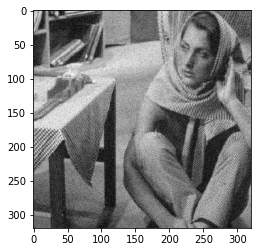

In [54]:
original_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/barbara.jpg')

steg_img = original_img.copy()

o_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
s_img = cv2.cvtColor(steg_img, cv2.COLOR_BGR2RGB)

cv2.imwrite('/content/drive/My Drive/Colab Notebooks/clone_img.jpeg',s_img)

plt.imshow(s_img)
plt.imshow(o_img)

# -1 means unknown, it will be automatically calculated
vector_img = o_img.reshape((-1, 3))
vector_img = np.float32(vector_img)
vector_img.shape

[[ 50  50  50]
 [115 115 115]
 [180 180 180]]


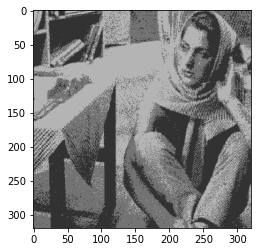

In [55]:

# criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 3
attempts = 1
ret, lable, center = cv2.kmeans(vector_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
print(center)
res = center[lable.flatten()]

res_image = res.reshape((o_img.shape))
plt.imshow(res_image)
clustered_img = Image.fromarray(res_image)
clustered_img.save('/content/drive/My Drive/Colab Notebooks/clustered_img.png')


In [56]:
def messageToBinary(message):
    if type(message) == str:
        return ''.join([ format(ord(i), "08b") for i in message ])
    elif type(message) == bytes: #or type(message) == np.ndarray:
        return ''.join([ format(i, "08b") for i in message ])
    elif type(message) == np.ndarray:
        return [format(i, "08b") for i in message]
    elif type(message) == int or type(message) == np.uint8:
        return format(message, "08b")
    else:
        raise TypeError("Input type not supported")

In [57]:
# Function to hide the secret message into the image

def hideData(image, msg):

    key = b'Sixteen byte key'
    if len(msg)%16 != 0:
      msg = msg + ' '*(16-len(msg)%16)

    print("Message:", msg, len(msg))
    msg = msg.encode()
    cipher = AES.new(key, AES.MODE_ECB)
    enc_msg = cipher.encrypt(msg)

    
    print("Encrypted message:", enc_msg)
    div_len = int(math.ceil(len(enc_msg)/3))
    chunk1 = enc_msg[0:div_len]
    chunk2 = enc_msg[div_len: 2*div_len]
    chunk3 = enc_msg[2*div_len:] + b'#####'

    
    n_bytes = image.shape[0] * image.shape[1] * 3 // 8
    # print("Maximum bytes to encode:", n_bytes)

    #Check if the number of bytes to encode is less than the maximum bytes in the image
    if len(msg) > n_bytes:
        raise ValueError("Error encountered insufficient bytes, need bigger image or less data !!")
  

    data_index = 0
    # convert input data to binary format using messageToBinary() fucntion
    binary_secret_chunk1_msg = messageToBinary(chunk1)
    binary_secret_chunk2_msg = messageToBinary(chunk2)
    binary_secret_chunk3_msg = messageToBinary(chunk3)

    data_len_chunk1 = len(binary_secret_chunk1_msg) #Find the length of data that needs to be hidden
    data_len_chunk2 = len(binary_secret_chunk2_msg)
    data_len_chunk3 = len(binary_secret_chunk3_msg)


    lable_index=0
    chunk1_index=0
    chunk2_index=0
    chunk3_index=0

    for values in image:
        for pixel in values:
            # convert RGB values to binary format
            r, g, b = messageToBinary(pixel)
  
            # modify the least significant bit only if there is still data to store

            if (lable[lable_index]==0):
              if chunk1_index < data_len_chunk1:
                  # hide the data into least significant bit of red pixel
                  pixel[0] = int(r[:-1] + binary_secret_chunk1_msg[chunk1_index], 2)
                  chunk1_index +=1
              if chunk1_index < data_len_chunk1:
                  # hide the data into least significant bit of green pixel
                  pixel[1] = int(g[:-1] + binary_secret_chunk1_msg[chunk1_index], 2)
                  chunk1_index +=1
              if chunk1_index < data_len_chunk1:
                  # hide the data into least significant bit of  blue pixel
                  pixel[2] = int(b[:-1] + binary_secret_chunk1_msg[chunk1_index], 2)
                  chunk1_index +=1

              if (lable[lable_index]==1):
                if chunk2_index < data_len_chunk2:
                    # hide the data into least significant bit of red pixel
                    pixel[0] = int(r[:-1] + binary_secret_chunk2_msg[chunk2_index], 2)
                    chunk2_index +=1
                if chunk2_index < data_len_chunk2:
                    # hide the data into least significant bit of green pixel
                    pixel[1] = int(g[:-1] + binary_secret_chunk2_msg[chunk2_index], 2)
                    chunk2_index +=1
                if chunk2_index < data_len_chunk2:
                    # hide the data into least significant bit of  blue pixel
                    pixel[2] = int(b[:-1] + binary_secret_chunk2_msg[chunk2_index], 2)
                    chunk2_index +=1
              
              if (lable[lable_index]==2):
                if chunk3_index < data_len_chunk3:
                    # hide the data into least significant bit of red pixel
                    pixel[0] = int(r[:-1] + binary_secret_chunk3_msg[chunk3_index], 2)
                    chunk3_index +=1
                if chunk3_index < data_len_chunk3:
                    # hide the data into least significant bit of green pixel
                    pixel[1] = int(g[:-1] + binary_secret_chunk3_msg[chunk3_index], 2)
                    chunk3_index +=1
                if chunk3_index < data_len_chunk3:
                    # hide the data into least significant bit of  blue pixel
                    pixel[2] = int(b[:-1] + binary_secret_chunk3_msg[chunk3_index], 2)
                    chunk3_index +=1
            
            if chunk1_index + chunk2_index + chunk3_index >= data_len_chunk1+data_len_chunk2+data_len_chunk3:
                break
            lable_index +=1
    
    # print("outside the nested loop")
    return image

In [58]:
def text(msg):

  image = cv2.imread('/content/drive/My Drive/Colab Notebooks/barbara.jpg')

  steg_img = hideData(image, msg)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/steg_img.png', steg_img)
  plt.imshow(steg_img)

Enter the message:     H
Message: H                16
Encrypted message: b"'\xf6FDk\xaaB\x13\x19\x8cG\t\x96\xd8\xda("


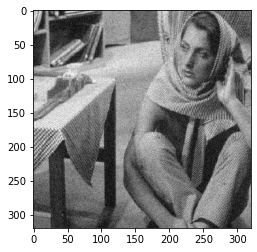

In [59]:
msg = input("Enter the message:     ")
text(msg)